In [1]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [2]:
## defining a frame for image and mask storage
framObjTrain = {'img' : [],
           'mask' : []
          }

framObjValidation = {'img' : [],
           'mask' : []
          }

## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    maskNames = os.listdir(maskPath)
    
    # ## generating mask names
    # for mem in imgNames:
    #     maskNames.append(re.sub('\.png', '_L.png', mem))
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        img = plt.imread(imgAddr + imgNames[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj

In [3]:
framObjTrain = LoadData( framObjTrain, imgPath = 'Amazon Forest Dataset/data/Training/images', 
                        maskPath = 'Amazon Forest Dataset/data/Training/masks', 
                        shape = 128)

In [4]:
framObjValidation  = LoadData( framObjValidation, imgPath = 'Amazon Forest Dataset/data/Validation/images', 
                              maskPath = 'Amazon Forest Dataset/data/Validation/masks',
                              shape = 128)

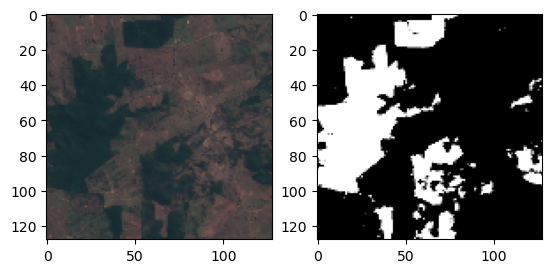

In [5]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][3])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][3])
plt.show()

In [6]:
# this block essentially performs 2 convolution
#     ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 128, 128, 3), found shape=(None, 256, 256, 3)


def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(4, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

## instanctiating model
inputs = tf.keras.layers.Input((128, 128, 3))
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )


In [7]:
## trainign our model
retVal = myTransformer.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 150, callbacks=[callback], verbose = 1)

Epoch 1/150
1/1 [==============================] - 12s 12s/step - loss: 0.7582 - accuracy: 0.1157
Epoch 2/150
1/1 [==============================] - 4s 4s/step - loss: 0.7047 - accuracy: 0.1329
Epoch 3/150
1/1 [==============================] - 3s 3s/step - loss: 0.6683 - accuracy: 0.1411
Epoch 4/150
1/1 [==============================] - 3s 3s/step - loss: 0.6423 - accuracy: 0.1488
Epoch 5/150
1/1 [==============================] - 3s 3s/step - loss: 0.6213 - accuracy: 0.1577
Epoch 6/150
1/1 [==============================] - 3s 3s/step - loss: 0.6022 - accuracy: 0.1676
Epoch 7/150
1/1 [==============================] - 3s 3s/step - loss: 0.5841 - accuracy: 0.1803
Epoch 8/150
1/1 [==============================] - 4s 4s/step - loss: 0.5670 - accuracy: 0.1975
Epoch 9/150
1/1 [==============================] - 4s 4s/step - loss: 0.5508 - accuracy: 0.2202
Epoch 10/150
1/1 [==============================] - 4s 4s/step - loss: 0.5352 - accuracy: 0.2476
Epoch 11/150
1/1 [===================

Text(0.5, 1.0, '')

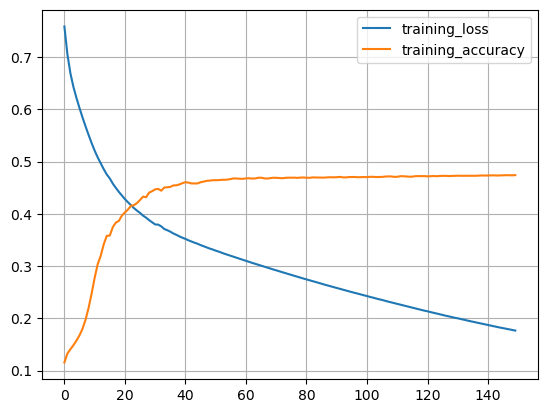

In [8]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)
plt.title("")

In [9]:
## function for getting 16 predictions
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2],predictions[i,:,:,3]))
    
    return predictions, imgProc, mask
    

    
    
def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(7,7))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask')

In [10]:
sixteenPrediction, actuals, masks = predict16(framObjValidation, myTransformer)


1/1 [==============================] - 1s 1s/step


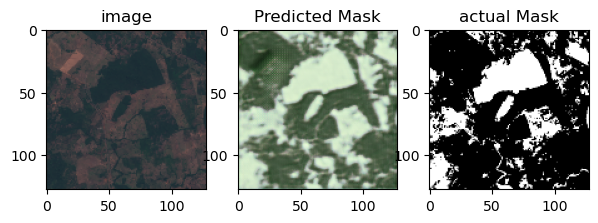

In [11]:
Plotter(actuals[1], sixteenPrediction[1], masks[1])


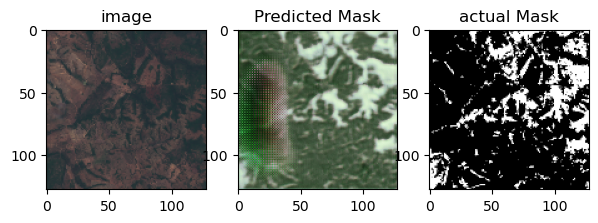

In [12]:
Plotter(actuals[3], sixteenPrediction[3], masks[3])


In [13]:
import numpy as np
import cv2

def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def predict16(valMap, model, shape=256):
    # getting and processing val data
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[:16]
    
    imgProc = img[:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i, :, :, 0], predictions[i, :, :, 1], predictions[i, :, :, 2], predictions[i, :, :, 3]))

    # Calculating IoU for each prediction
    iou_scores = [calculate_iou(mask[i], predictions[i] > 0.5) for i in range(len(predictions))]
    
    # Calculating average test accuracy (IoU)
    average_iou = np.mean(iou_scores)
    
    return predictions, imgProc, mask, average_iou


In [14]:
sixteenPrediction, actuals, masks, acc_scores = predict16(framObjValidation, myTransformer)


1/1 [==============================] - 0s 386ms/step


In [15]:
acc_scores

0.8560456453910528

# Bolivia: 

In [18]:
basePAth_hungary = 'augmentation/hungry_test'

list_of_names = os.listdir(basePAth_hungary)

In [21]:
# Loading data: 

def LoadData_bolivia( frameObj = None, imgPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    
    # ## generating mask names
    # for mem in imgNames:
    #     maskNames.append(re.sub('\.png', '_L.png', mem))
    
    imgAddr = imgPath + '/'
    
    for i in range (len(imgNames)):
        img = plt.imread(imgAddr + imgNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        
        frameObj['img'].append(img)
        
    return frameObj



In [29]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

def LoadData_bolivia(frameObj=None, imgPath=None, shape=256):
    imgNames = os.listdir(imgPath)

    imgAddr = imgPath + '/'

    for i in range(len(imgNames)):
        img = plt.imread(imgAddr + imgNames[i])

        # Ensure the image has 3 channels (RGB)
        if img.shape[-1] != 3:
            # If not, convert to RGB
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

        img = cv2.resize(img, (shape, shape))

        frameObj['img'].append(img)

    return frameObj


In [30]:
## defining a frame for image and mask storage
framObj_Bolivia = {'img' : []}

framObj_Bolivia = LoadData_bolivia( framObj_Bolivia, imgPath = basePAth_hungary, 
                        shape = 128)

len(framObj_Bolivia['img'])

5

In [48]:

# Assuming img is your single image with shape (128, 128, 3)
img = framObj_Bolivia['img'][0]
img = cv2.resize(img, (128, 128))  # Ensure the image is the desired size
img = np.expand_dims(img, axis=0)  # Add a batch dimension

# Now, img has shape (1, 128, 128, 3)
preds = myTransformer.predict(img)


1/1 [==============================] - 0s 58ms/step


In [52]:
preds.shape

preds_img = preds[0]

In [ ]:
sixteenPrediction, actuals, masks = predict16(framObjValidation, myTransformer)


In [75]:
## function for getting 16 predictions
def predict_Bolivia(valMap, model, shape = 128):
    ## getting and proccessing val data
    img = valMap['img']
    
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    # for i in range(len(predictions)):
    #     predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2],predictions[i,:,:,3]))
    
    return predictions, imgProc
    

In [76]:
preds, proc = predict_Bolivia(framObj_Bolivia, myTransformer, shape = 128)    

1/1 [==============================] - 0s 185ms/step


In [82]:
def Plotter(img, predMask):
    plt.figure(figsize=(7,7))
    
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,2,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')

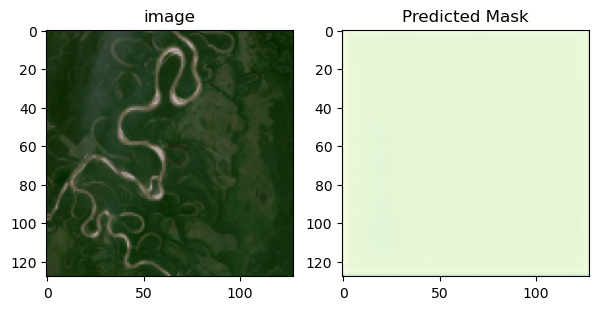

In [81]:
Plotter(proc[2], preds[2])

In [86]:
preds[2]

preds[2].shape

type(preds[2])

numpy.ndarray

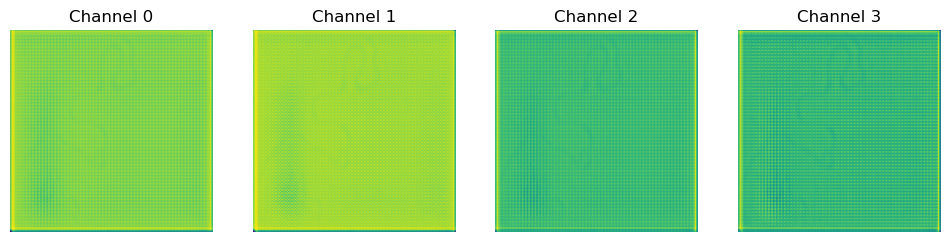

In [102]:
image_array = preds[2]

# Display each channel separately
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for i in range(4):
    axes[i].imshow(image_array[:, :, i])  # Assuming grayscale for each channel
    axes[i].set_title(f'Channel {i}')
    axes[i].axis('off')

plt.show()

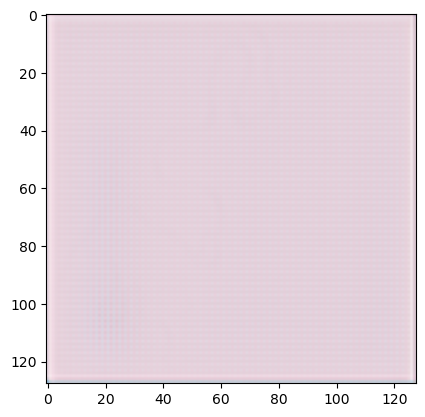

In [101]:
import matplotlib.pyplot as plt

# Omit channel 2 (Green channel)
rgb_image = np.delete(image_array, 1, axis=2)

# Display the RGB image without channel 2
plt.imshow(rgb_image)
plt.show()
